In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import random
from scipy.stats import pearsonr
from scipy.spatial import distance
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=20,20

pd.set_option('display.max_rows', 6000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

Carrega a base de voos

In [3]:
international_flights = pd.read_csv('international_graph.csv')
international_flights = international_flights[['pais_origem', 'pais_destino', 'qtde_voos']]
international_flights = international_flights.set_index(['pais_origem', 'pais_destino'])

Descomentar para testes:

countries_loc = ['Brazil', 'Italy', 'China', 'United States', 'France', 'Germany', 'Iran', 'United Kingdom']
international_flights_loc = pd.DataFrame(columns=['pais_origem', 'pais_destino', 'qtde_voos'])

for index in international_flights.index:
    if index[0] in countries_loc and index[1] in countries_loc:
        df = pd.DataFrame({'pais_origem': [index[0]], 'pais_destino': [index[1]], 'qtde_voos': [float(international_flights.loc[index])]})
        international_flights_loc = international_flights_loc.append(df, ignore_index=True)

international_flights = international_flights_loc.set_index(['pais_origem', 'pais_destino'])

In [4]:
international_flights.head()

qtde_voos
pais_origem pais_destino           
Algeria     Argentina      0.001370
            Austria        0.173973
            Belgium        0.253425
            Brazil         0.021918
            Canada         0.272603

Constrói o vetor de correlação com a média de voos entre os países

In [5]:
international_flights_avg = pd.DataFrame(columns = ['source', 'target', 'value'])
indexes = international_flights.index
international_flights_avg_list = international_flights_avg[['source', 'target']].values.tolist()


for index in indexes:
    if list(index) not in international_flights_avg_list:
        if (index[1], index[0]) not in indexes:
            value_1 = [[index[0], index[1], international_flights.loc[(index[0], index[1])].qtde_voos]]
            value_2 = [[index[1], index[0], international_flights.loc[(index[0], index[1])].qtde_voos]]
        else:
            base_value =  (international_flights.loc[(index[0], index[1])].qtde_voos + international_flights.loc[(index[1], index[0])].qtde_voos)/2
            value_1 = [[index[0], index[1], base_value]]
            value_2 = [[index[1], index[0], base_value]]

        df = pd.DataFrame(value_1, columns=['source', 'target', 'value'])
        international_flights_avg = international_flights_avg.append(df, ignore_index = True)
        df = pd.DataFrame(value_2, columns=['source', 'target', 'value'])
        international_flights_avg = international_flights_avg.append(df, ignore_index = True) 
        
        international_flights_avg_list = international_flights_avg[['source', 'target']].values.tolist()
        

In [6]:
international_flights_avg.to_csv('transition_matrix_edge_list.csv', index=False)
international_flights_avg.head()

,source,target,value
0,Algeria,Argentina,0.005479
1,Argentina,Algeria,0.005479
2,Algeria,Austria,0.141781
3,Austria,Algeria,0.141781
4,Algeria,Belgium,0.307534


Constrói o grafo com a probabilidade de voos entre países

In [7]:
country_international_flights = international_flights_avg.groupby(['source']).sum() 
transition_matrix = international_flights_avg.copy()
transition_matrix = transition_matrix.drop(columns= ['value'])

transition_matrix['prob'] = 0.

for index, row in international_flights_avg.iterrows():
    weight = float(country_international_flights.loc[row['source']])
    transition_matrix.loc[index,'prob'] = row['value']/weight


In [8]:
transition_matrix.to_csv('probability_matrix.csv', index=False)
transition_matrix.head()

,source,target,prob
0,Algeria,Argentina,0.000300
1,Argentina,Algeria,0.000166
2,Algeria,Austria,0.007769
3,Austria,Algeria,0.000590
4,Algeria,Belgium,0.016851


In [9]:
transition_matrix_crosstab = pd.crosstab(transition_matrix['target'], transition_matrix['source'], transition_matrix['prob'], aggfunc=sum)
transition_matrix_crosstab = transition_matrix_crosstab.fillna(0)

In [10]:
transition_matrix_crosstab

source,Algeria,Anguilla,Argentina,Armenia,Aruba,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Bermuda,Bolivia,Bosnia and Herzegovina,Brazil,British Virgin Islands,Brunei,Bulgaria,Canada,Cape Verde,Chile,China,Colombia,Costa Rica,Croatia,Cyprus,Czech Republic,Denmark,Dominican Republic,Ecuador,Egypt,Estonia,Finland,France,French Polynesia,Gambia,Georgia,Germany,Gibraltar,Greece,Grenada,Guatemala,Guernsey,Guinea,Guinea-Bissau,Haiti,...,New Caledonia,New Zealand,Norway,Oman,Pakistan,Palestine,Panama,Peru,Philippines,Poland,Portugal,Puerto Rico,Qatar,Reunion,Romania,Russia,Saint Lucia,Saint Pierre and Miquelon,Saint Vincent and the Grenadines,Saudi Arabia,Senegal,Serbia,Singapore,Slovakia,Slovenia,South Africa,South Korea,Spain,Sri Lanka,Suriname,Sweden,Switzerland,Taiwan,Tajikistan,Thailand,Trinidad and Tobago,Tunisia,Turkey,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,Uzbekistan,Venezuela,Vietnam,Virgin Islands,West Bank,Western Sahara,Zambia
target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Algeria,0.000000,0.0,0.000166,0.000000,0.000000,0.000000,0.000590,0.000000,0.000000,0.000128,0.000345,0.000000,0.000000,0.001642,0.0,0.000000,0.000000,0.000000,0.000325,0.000000,0.000000,0.000000,0.000801,0.000000,0.000000,0.000000,0.000245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001887,0.000000,0.000000,0.015935,0.000000,0.000933,0.000000,0.000561,0.000000,0.000048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000018,0.000000,0.001307,0.0,0.000000,0.000000,0.000101,0.000000,0.000570,0.000000,0.003217,0.000000,0.000000,0.000244,0.000000,0.000000,0.000000,0.001162,0.028759,0.000077,0.000000,0.000000,0.000000,0.000166,0.000000,0.003552,0.000000,0.000000,0.000013,0.000813,0.000000,0.000000,0.000000,0.000000,0.000816,0.005329,0.000000,0.002236,0.000451,0.000012,0.000307,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
Anguilla,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000094,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
Argentina,0.000300,0.0,0.000000,0.000000,0.000466,0.000675,0.000006,0.000000,0.000000,0.000000,0.002070,0.000000,0.000000,0.000135,0.0,0.000239,0.197832,0.000000,0.180545,0.000000,0.000000,0.000000,0.001356,0.001987,0.208369,0.000000,0.020421,0.006727,0.000000,0.000000,0.000038,0.000000,0.019744,0.064713,0.000000,0.000000,0.000000,0.001056,0.000960,0.000000,0.000000,0.000571,0.000000,0.000019,0.000000,0.003895,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.005641,0.000000,0.000000,0.000000,0.0,0.026452,0.098779,0.000081,0.000025,0.000027,0.000897,0.000047,0.017647,0.000000,0.000050,0.000000,0.000000,0.000000,0.000038,0.002801,0.000000,0.000000,0.000000,0.000000,0.000222,0.000029,0.006148,0.000000,0.000000,0.000006,0.000350,0.000000,0.000000,0.000019,0.000000,0.000148,0.000016,0.000000,0.000016,0.000894,0.008633,0.302989,0.000000,0.084052,0.000000,0.000000,0.000000,0.0,0.000000
Armenia,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000097,0.000000,0.000000,0.000000,0.000000,0.000000,0.001911,0.000011,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

Carrega o arquivo com o total diário de casos e pega o dia específico - 77

In [54]:
total_cases = pd.read_csv('total_cases_countries_normalized.csv')
total_cases = total_cases[['Name', 'Day', 'Total']].set_index(['Name', 'Day'])

countries = transition_matrix_crosstab.columns.to_list()

indexes = []
for index in total_cases.index:
    indexes.append(index)

daily_cases = pd.DataFrame(columns=['n_cases'], index=[countries])

for country in countries:
    if (country, 77) not in indexes:
        daily_cases.loc[country, 'n_cases'] = 0. 
    else:
        daily_cases.loc[country, 'n_cases'] = total_cases.loc[country, 77][0]

In [55]:
daily_cases

,n_cases
Algeria,58
Anguilla,0
Argentina,65
Armenia,52
Aruba,2
Australia,375
Austria,1016
Azerbaijan,19
Bahamas,1
Bahrain,221


Faz o random walk

In [56]:
def new_state_df(initial_number, transition_matrix_crosstab):

    state_df = pd.DataFrame(index=transition_matrix_crosstab.columns, columns = ['n_cases'])

    for country in state_df.index:
        if country == 'China':
            state_df.loc[country, 'n_cases'] = float(initial_number)
        else:
            state_df.loc[country, 'n_cases'] = 0.
            
    return state_df


Cria o dataframe a ser utilizado e roda o gridsearch

In [57]:
np.arange(1.,1.5,0.02)

array([1.  , 1.02, 1.04, 1.06, 1.08, 1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 ,
       1.22, 1.24, 1.26, 1.28, 1.3 , 1.32, 1.34, 1.36, 1.38, 1.4 , 1.42,
       1.44, 1.46, 1.48])

In [58]:
contamination_rate = np.arange(1.,1.5,0.02)
initial_number = [x for x in range(10,510,10)] 
correlation_df = pd.DataFrame(columns=['V', 'R', 'Euclidean Distance'])

def model_spread(v, r):
    state_df = new_state_df(v, transition_matrix_crosstab)
    for i in range(78):
        if i == 0:
            state_df = transition_matrix_crosstab.dot(state_df)
        else:
            state_df = transition_matrix_crosstab.dot(state_df)
            state_df = state_df*r
    return state_df

for v in initial_number:
    for r in contamination_rate: 
        state_df = model_spread(v, r)
                
        dist_euclidean = distance.euclidean(daily_cases, state_df)
        
        df = pd.DataFrame([{'V': v, 'R': r, 'Euclidean Distance': dist_euclidean}])
        correlation_df = correlation_df.append(df, ignore_index=True)
        
        if v==10 and r == 1.:
            min_dist = dist_euclidean
            v_min_dist = v
            r_min_dist = r
            
        elif abs(dist_euclidean)<abs(min_dist):
            min_dist = dist_euclidean
            v_min_dist = v
            r_min_dist = r
        
print('Menor distancia Euclideana: ' + str(min_dist))
print('V: ' + str(v_min_dist))
print('R: ' + str(r_min_dist))

Menor distancia Euclideana: 86818.11723161727
V: 260
R: 1.08


In [59]:
state_df_final = model_spread(v_min_dist, r_min_dist)

print(state_df_final.sum())

state_df_final

n_cases    97409.770574
dtype: float64


,n_cases
target,
Algeria,154.172
Anguilla,0.0115719
Argentina,278.24
Armenia,9.13599
Aruba,24.8564
Australia,1046.33
Austria,2030.42
Azerbaijan,1.27869
Bahamas,14.1003


In [60]:
print(daily_cases.sum())

daily_cases

n_cases    183806.0
dtype: float64


,n_cases
Algeria,58
Anguilla,0
Argentina,65
Armenia,52
Aruba,2
Australia,375
Austria,1016
Azerbaijan,19
Bahamas,1
Bahrain,221


In [61]:
pearsonr(state_df_final.T.values[0], daily_cases.T.values[0])

(0.18075759261132185, 0.03134210227014997)

In [62]:
correlation_pivot = correlation_df.pivot(index='V', columns='R', values='Euclidean Distance')
correlation_pivot

R,1.00,1.02,1.04,1.06,1.08,1.10,1.12,1.14,1.16,1.18,1.20,1.22,1.24,1.26,1.28,1.30,1.32,1.34,1.36,1.38,1.40,1.42,1.44,1.46,1.48
V,,,,,,,,,,,,,,,,,,,,,,,,,
10,89237.436123,89235.646408,89227.738292,89193.884820,89054.785944,88530.112059,87130.023274,9.225588e+04,1.973326e+05,7.224776e+05,2.672490e+06,9.591031e+06,3.359532e+07,1.152202e+08,3.874528e+08,1.278514e+09,4.142522e+09,1.318691e+10,4.126388e+10,1.269884e+11,3.845325e+11,1.146243e+12,3.365009e+12,9.732944e+12,2.774766e+13
20,89236.938118,89233.359677,89217.563061,89150.224027,88878.582243,87941.535055,87017.495061,1.201487e+05,3.849771e+05,1.457715e+06,5.363504e+06,1.920212e+07,6.721111e+07,2.304610e+08,7.749263e+08,2.557048e+09,8.285065e+09,2.637384e+10,8.252778e+10,2.539767e+11,7.690650e+11,2.292487e+12,6.730018e+12,1.946589e+13,5.549532e+13
30,89236.440163,89231.073985,89207.408492,89106.952367,88709.364455,87474.610239,88907.926356,1.604278e+05,5.794524e+05,2.194731e+06,8.054992e+06,2.881333e+07,1.008269e+08,3.457018e+08,1.162400e+09,3.835583e+09,1.242761e+10,3.956078e+10,1.237917e+11,3.809651e+11,1.153598e+12,3.438730e+12,1.009503e+13,2.919883e+13,8.324299e+13
40,89235.942258,89228.789331,89197.274590,89064.070408,88547.172630,87131.293383,92678.831036,2.059498e+05,7.756373e+05,2.932184e+06,1.074660e+07,3.842458e+07,1.344428e+08,4.609426e+08,1.549873e+09,5.114117e+09,1.657015e+10,5.274771e+10,1.650556e+11,5.079535e+11,1.538130e+12,4.584973e+12,1.346004e+13,3.893177e+13,1.109906e+14
50,89235.444401,89226.505715,89187.161363,89021.578713,88392.045446,86913.049299,98113.625490,2.539101e+05,9.724978e+05,3.669811e+06,1.343825e+07,4.803584e+07,1.680586e+08,5.761834e+08,1.937347e+09,6.392652e+09,2.071269e+10,6.593464e+10,2.063195e+11,6.349419e+11,1.922663e+12,5.731217e+12,1.682504e+13,4.866472e+13,1.387383e+14
60,89234.946593,89224.223137,89177.068818,88979.477840,88244.020159,86820.821189,104954.145809,3.031537e+05,1.169693e+06,4.407524e+06,1.612992e+07,5.764711e+07,2.016745e+08,6.914242e+08,2.324820e+09,7.671186e+09,2.485524e+10,7.912158e+10,2.475834e+11,7.619302e+11,2.307195e+12,6.877460e+12,2.019005e+13,5.839766e+13,1.664860e+14
70,89234.448835,89221.941598,89166.996962,88937.768346,88103.132567,86855.010490,112945.267141,3.531442e+05,1.367077e+06,5.145287e+06,1.882161e+07,6.725838e+07,2.352903e+08,8.066650e+08,2.712294e+09,8.949721e+09,2.899778e+10,9.230851e+10,2.888473e+11,8.889186e+11,2.691728e+12,8.023704e+12,2.355506e+13,6.813061e+13,1.942336e+14
80,89233.951126,89219.661097,89156.945801,88896.450780,87969.416962,87015.468189,121860.844604,4.036042e+05,1.564580e+06,5.883080e+06,2.151331e+07,7.686965e+07,2.689062e+08,9.219058e+08,3.099767e+09,1.022826e+10,3.314032e+10,1.054954e+11,3.301112e+11,1.015907e+12,3.076260e+12,9.169947e+12,2.692007e+13,7.786355e+13,2.219813e+14
90,89233.453466,89217.381634,89146.915344,88855.525691,87842.906098,87301.498056,131512.999194,4.543772e+05,1.762161e+06,6.620894e+06,2.420501e+07,8.648093e+07,3.025220e+08,1.037147e+09,3.487241e+09,1.150679e+10,3.728287e+10,1.186824e+11,3.713751e+11,1.142895e+12,3.460793e+12,1.031619e+13,3.028508e+13,8.759649e+13,2.497290e+14


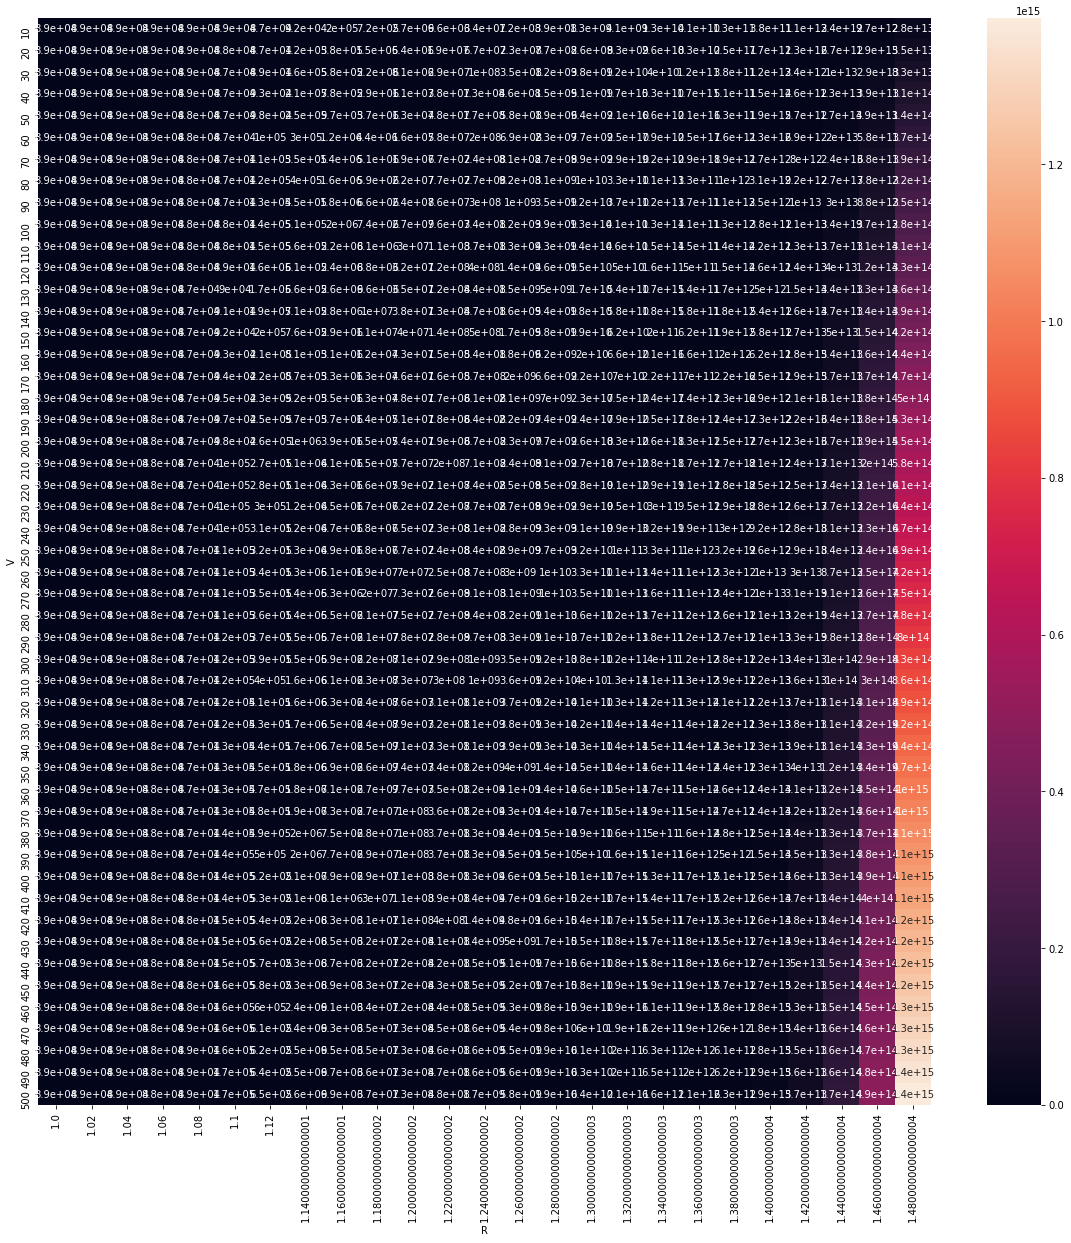

In [63]:
heatmap = sns.heatmap(correlation_pivot, annot=True)

In [64]:
state_df = new_state_df(10, transition_matrix_crosstab)

for i in range(78):
    if i == 0:
        state_df = transition_matrix_crosstab.dot(state_df)
    else:
        state_df = transition_matrix_crosstab.dot(state_df)
        state_df = state_df*1.1
        
state_df.to_csv('state_vector.csv')

In [65]:
state_df.head()

,n_cases
target,
Algeria,24.3579
Anguilla,0.00182826
Argentina,43.9595
Armenia,1.44341
Aruba,3.9271
